# Aquatic Algorithms Part 1: Streamflow analysis

Step 0: Choose your case study location

Step 1: Get streamflow data for your location

Step 2: Visualize the streamflow timeseries

Step 3: Get the minimum and maximum flow values from history

***
## Step 0: Choose your case study location

Before getting started with the code, vist the [USGS National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/en/?region=lower48&aoi=default) and find your case study, then select one streamflow gauge to use for this analysis and assign it to the variable (`station_id`) below.

> **Note:** This code, and others used during the internship will make different results based on the unique gauge you choose... feel free to try different gauges by changing the `station_id` and re-running the code.
 


In [42]:
# Add your own gauge ID here (make sure it is a string):
station_id = '04234000'

# Add the time-range of interest
dates = ("1990-01-01", "2022-12-31")

We can get streamflow from the USGS website directly, but this tends to be more difficult and requires manually manipulating the data before we can use it.  Fortunately, there is an open-source Python package called `pygeohydro` which makes it each retrieve streamflow data more easily.

You can visit the [documentation for the PyGeoHydro](https://hyriver.readthedocs.io/en/latest/readme/pygeohydro.html) if you want to read more above the technical details at any point.

Let's start by importing the `pygeohydro` library.  We will also want to import the `numpy`, `pandas`, and `matplotlib` libraries (we will do this in almost all notebooks):

In [43]:
import pandas as pd
import numpy as np

import pygeohydro as gh
from pygeohydro import NWIS

from AquaticAlgorithms.plotting.timeseries_plots import plot_streamflow_by_year


In [58]:
# Request the flow data
flow = NWIS().get_streamflow(station_id, dates, mmd=True)

flow.index = pd.to_datetime(flow.index.date)
flow.head()

flow.columns=['streamflow']

## Step 2: Visualize streamflow history

The best way to get familiar with a set of data is to look at a variety of different visualizations.  

Data scientists must be able to "tell a story" with the data they have or else people will not be paying attention.  

Let's make a few nice plots to show off the streamflow data that we collected. Here, we are going to use the `matplotlib` package to help make our plots. 

Be sure to read the comments (`#`) to try and understand what each part of the plotting code is doing.  By understanding how to change small parts of the plot you will later be able to make more unique visuals. 

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np


In [50]:
def plot_streamflow_by_year(df, log_scale=False, 
                            save_fig=False, save_name='streamflow_by_year.png'):
    
    # Create a new column for the year
    df['Year'] = df.index.year
    
    # Calculate the total streamflow for each year
    df['Total_Streamflow'] = df.groupby('Year')['streamflow'].transform('sum')

    # Sort the dataframe by the total streamflow for each year
    sorted_df = df.sort_values('Total_Streamflow', inplace=False)

    # Create a colormap to map each year to a color based on its total streamflow
    colormap = cm.get_cmap('viridis')
    colors = colormap(np.linspace(0, 1, sorted_df['Year'].nunique()))

    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the streamflow for each year
    for i, year in enumerate(df['Year'].unique()):
        df_year = df[df['Year'] == year]
        ax.plot(df_year.index.dayofyear, df_year['streamflow'], 
                color=colors[i], label=year, alpha=0.3)

    # Set the y-axis to a log scale if specified
    if log_scale:
        ax.set_yscale('log')

    # Set the x-axis to show only the month
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Save the figure if specified
    if save_fig:
        plt.savefig(save_name)

    # Show the plot
    plt.show()
    return

In [76]:
def plot_streamflow_by_year(df, log_scale=False, 
                            save_fig=False, save_name='streamflow_by_year.png',
                            group_by='day', fill_range=False,
                            highlight_driest_year=False, highlight_wettest_year=False):

    # Create a new column for the year
    df = df.copy()
    df['Year'] = df.index.year

    # Group by the specified period
    if group_by == 'month':
        df_grouped = df.groupby([df.index.year.rename('Year'), df.index.month.rename('Month')])['streamflow'].sum()
        df_grouped.index.names = ['Year', 'Period']
    elif group_by == 'week':
        df_grouped = df.groupby([df.index.year.rename('Year'), df.index.weekofyear.rename('Week')])['streamflow'].sum()
        df_grouped.index.names = ['Year', 'Period']
    else:
        df_grouped = df.groupby([df.index.year.rename('Year'), df.index.dayofyear.rename('Day')])['streamflow'].mean()
        df_grouped.index.names = ['Year', 'Period']

    # Calculate the total streamflow for each year
    df_grouped = df_grouped.reset_index()
    df_grouped['Total_Streamflow'] = df_grouped.groupby('Year')['streamflow'].transform('sum')

    # Identify the driest and wettest years
    driest_year = df_grouped.groupby('Year')['Total_Streamflow'].sum().idxmin() if highlight_driest_year else None
    wettest_year = df_grouped.groupby('Year')['Total_Streamflow'].sum().idxmax() if highlight_wettest_year else None

    # Sort the dataframe by the total streamflow for each year
    sorted_df = df_grouped.sort_values('Total_Streamflow', inplace=False)

    # Create a colormap to map each year to a color based on its total streamflow
    colormap = cm.get_cmap('viridis')
    colors = colormap(np.linspace(0, 1, sorted_df['Year'].nunique()))

    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the streamflow for each year
    for i, year in enumerate(sorted_df['Year'].unique()):
        df_year = sorted_df[sorted_df['Year'] == year]
        if fill_range:
            ax.fill_between(df_year['Period'], df_year['streamflow'].min(), df_year['streamflow'].max(), 
                            color=colors[i], alpha=0.3, label=year)
        else:
            ax.plot(df_year['Period'], df_year['streamflow'], color=colors[i], alpha=0.3, label=year)
        
        if year == driest_year:
            ax.plot(df_year['Period'], df_year['streamflow'], color='red', linewidth=2, label=f'{year} (Driest)')
        if year == wettest_year:
            ax.plot(df_year['Period'], df_year['streamflow'], color='blue', linewidth=2, label=f'{year} (Wettest)')

    # Set the y-axis to a log scale if specified
    if log_scale:
        ax.set_yscale('log')

    # Set the x-axis to show only the month
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    

    # Save the figure if specified
    if save_fig:
        plt.savefig(save_name)

    # Show the plot
    plt.show()
    return



C:\Users\tjame\AppData\Local\Temp\ipykernel_16076\3373443773.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis')


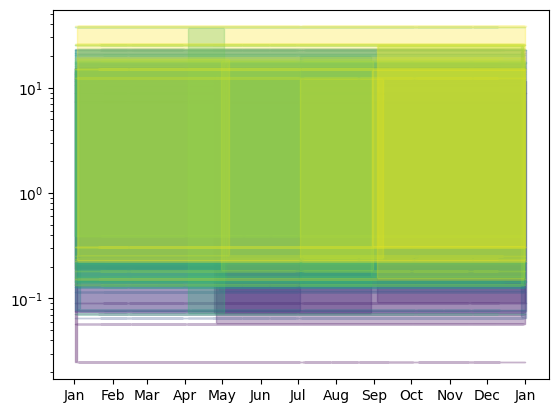

In [77]:

plot_streamflow_by_year(flow, log_scale=True,
                        group_by='day', fill_range=True)


In [78]:
flow

,streamflow
1990-01-01,0.747683
1990-01-02,0.687868
1990-01-03,0.672914
1990-01-04,0.628053
1990-01-05,1.495365
...,...
2022-12-27,1.689763
2022-12-28,1.592564
2022-12-29,1.457981
2022-12-30,2.482307


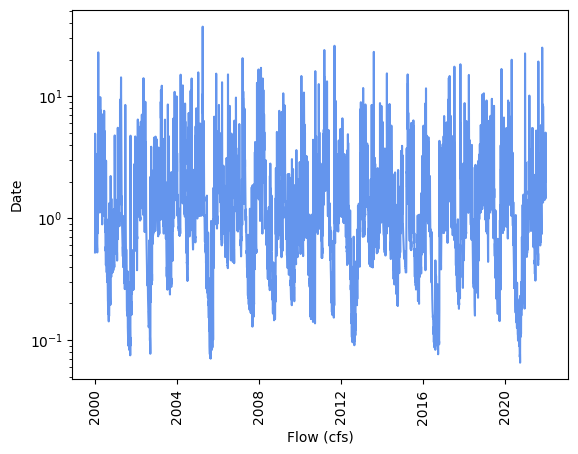

In [50]:
start_date = '2000-01-01'
end_date = '2022-01-01'

# Create the "figure" object
fig = plt.figure()

# Add a "subplot" axis (ax) to the figure; we will add the data onto the subplot
ax = fig.add_subplot()

x = flow.loc[start_date:end_date, :].index
y = flow.loc[start_date:end_date,:]
ax.plot(x, y, color = 'cornflowerblue', linewidth = 1.5, label = 'Flow')

ax.set_ylabel('Date')
ax.set_xlabel('Flow (cfs)')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

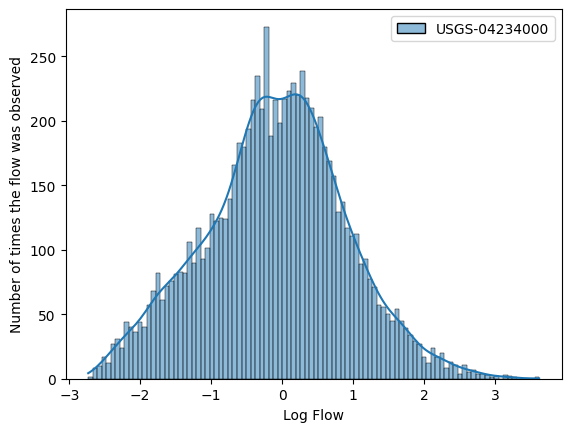

In [51]:
fig, ax = plt.subplots()


sns.histplot(np.log(flow), ax = ax, 
             color = 'cornflowerblue', 
             bins = 100, kde=True)

plt.ylabel('Number of times the flow was observed')
plt.xlabel('Log Flow')

plt.show()

type: 'tuple' object has no attribute 'pdf'

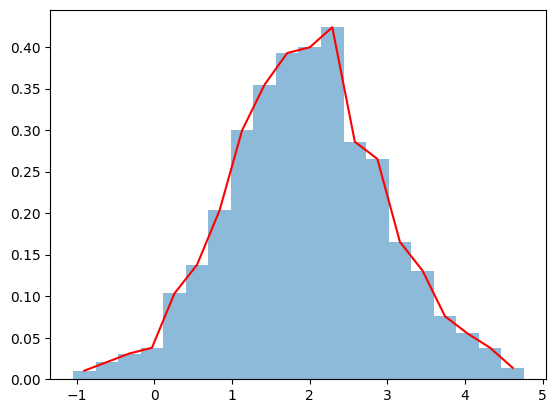

In [52]:
# Generate random data from a known distribution
np.random.seed(0)
data = np.random.normal(loc=2, scale=1, size=1000)

# Define the number of bins for histogram representation
num_bins = 20

# Estimate the probability distribution using maximum likelihood method (histogram)
hist_values, bin_edges = np.histogram(data, bins=num_bins, density=True)
hist_midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Estimate the probability distribution using maximum entropy method
entropy_dist = stats.rv_histogram((hist_values, bin_edges))
max_entropy_dist = entropy_dist.fit(data)

# Plot the original distribution, maximum likelihood estimate, and maximum entropy estimate
plt.hist(data, bins=num_bins, density=True, alpha=0.5, label='Original Data')
plt.plot(hist_midpoints, hist_values, 'r-', label='Maximum Likelihood Estimate')
plt.plot(hist_midpoints, max_entropy_dist.pdf(hist_midpoints), 'g-', label='Maximum Entropy Estimate')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Comparison of Maximum Likelihood and Maximum Entropy Estimates')
plt.legend()
plt.show()

In [53]:
max_entropy_dist

(-0.00028506685692380893, 1.006459357926156)

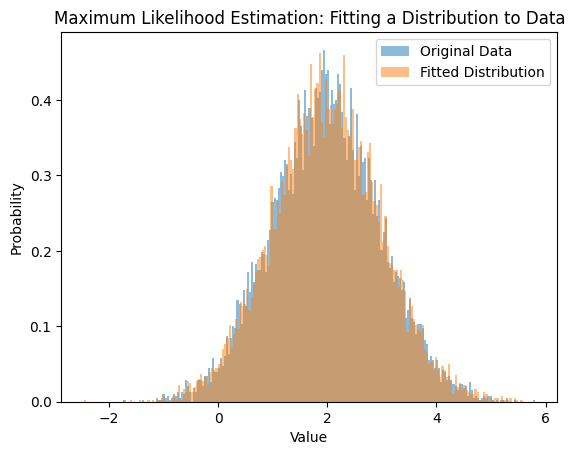

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate random data from a known distribution
np.random.seed(0)
data = np.random.normal(loc=2, scale=1, size=10000)

# Fit a distribution to the data using maximum likelihood estimation
best_fit_params, best_fit_covariance = stats.norm.fit(data)

# Generate random samples from the fitted distribution
fitted_dist = stats.norm(best_fit_params)
samples = fitted_dist.rvs(10000)

# Plot the histogram of the original data and the fitted distribution
plt.hist(data, bins=200, density=True, alpha=0.5, label='Original Data')
plt.hist(samples, bins=200, density=True, alpha=0.5, label='Fitted Distribution')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Maximum Likelihood Estimation: Fitting a Distribution to Data')
plt.legend()
plt.show()


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate random data from a known distribution
np.random.seed(0)
data = np.random.normal(loc=2, scale=1, size=1000)

# Define the number of bins for histogram representation
num_bins = 30

# Estimate the probability distribution using maximum entropy principle
hist_values, bin_edges = np.histogram(data, bins=num_bins, density=True)
hist_midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Define constraints for maximum entropy estimation
constraints = [{'type': 'mean', 'value': np.mean(data)},
               {'type': 'var', 'value': np.var(data)}]

# Estimate the probability distribution using maximum entropy principle
max_entropy_dist = stats.rv_histogram((hist_values, bin_edges))
params = max_entropy_dist.fit(data, floc=hist_midpoints[0], fscale=hist_midpoints[-1], 
                              floc_kw={'fixed': True}, 
                              fscale_kw={'fixed': True},
                              optimizer=None, constraints=constraints)

# Generate random samples from the fitted distribution
fitted_dist = max_entropy_dist(*params[:-2], loc=params[-2], scale=params[-1])
samples = fitted_dist.rvs(1000)

# Plot the histogram of the original data and the fitted distribution
plt.hist(data, bins=num_bins, density=True, alpha=0.5, label='Original Data')
plt.hist(samples, bins=num_bins, density=True, alpha=0.5, label='Fitted Distribution')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Maximum Entropy Estimation: Fitting a Distribution to Data')
plt.legend()
plt.show()


type: All parameters fixed. There is nothing to optimize.

In [65]:
hist_values, bin_edges = np.histogram(data, bins=num_bins, density=True)
hist_midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Define constraints for maximum entropy estimation
constraints = [{'type': 'mean', 'value': np.mean(data)},
               {'type': 'var', 'value': np.var(data)}]

# Estimate the probability distribution using maximum entropy principle
max_entropy_dist = stats.rv_histogram((hist_values, bin_edges))

In [70]:
max_entropy_dist.entropy()

1.3924353365168334

In [71]:
stats.entropy()

array([8.53822172])

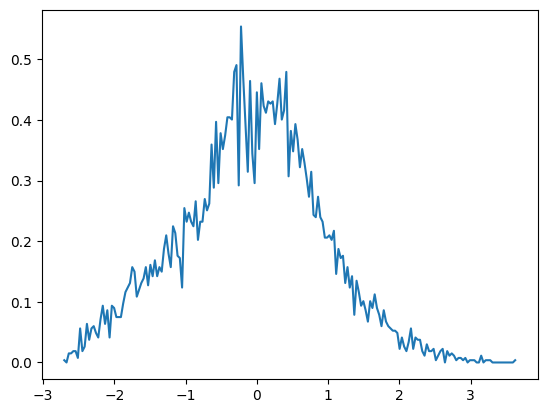

In [91]:
plt.plot(xi[1:], pi)

In [94]:
stats.rv_histogram((pi, xi)).pdf(1)

0.209754920451809

In [95]:
gen_y = []
for i in np.linspace(-3,3,200):
    gen_y.append(stats.rv_histogram((pi,xi)).pdf(i))

In [98]:
stats.rv_histogram((pi,xi)).fit(flow.values.flatten())

(-0.7564482897446472, 8.248183092756314)